<a href="https://www.kaggle.com/code/jaehyukj3/resource-utilization-data?scriptVersionId=251785823" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Resource_utilization.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# matplotlib, seaborn의 경고 메시지를 무시하도록 설정
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

In [3]:
df = pd.read_csv('/kaggle/input/Resource_utilization.csv')

print(df.head())
print(df.info())
print(df.describe())

             timestamp  cpu_utilization  memory_usage  storage_usage  \
0  2024-05-15 06:00:00        93.667656     65.739742      81.202149   
1  2022-03-20 00:00:00              NaN     45.771232      56.178079   
2  2024-03-31 02:00:00        66.270283     85.537221      61.594411   
3  2022-10-05 07:00:00        50.305590     55.492008     100.419747   
4  2022-07-18 08:00:00        58.567954     77.339342      60.446444   

    workload  Resource Allocation  
0  100.00000            76.398051  
1   96.20153            52.783747  
2  100.00000            71.699889  
3  100.00000            69.456805  
4  100.00000            66.624977  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26305 entries, 0 to 26304
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            26305 non-null  object 
 1   cpu_utilization      23486 non-null  float64
 2   memory_usage         23234 non-null  f

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [4]:
from scipy.stats import zscore

# 1. 컬럼 이름 변경
df.rename(columns={'Resource Allocation': 'resource_allocation'}, inplace=True)

# 2. 'timestamp' 컬럼 datetime 타입으로 변환
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# 3. NaT가 된 timestamp 행 제거
if df['timestamp'].isnull().sum() > 0:
    print(f"경고: 'timestamp' 변환 중 {df['timestamp'].isnull().sum()}개의 NaT 값이 생성되었습니다.")
    df.dropna(subset=['timestamp'], inplace=True)
    print("NaT 값을 가진 timestamp 행을 제거했습니다.")

print("\n'timestamp' 컬럼 타입 변환 후 정보")
print(df['timestamp'].dtype)

# 4. 결측치 처리 (기존 결측치)
print("\n결측치 처리 전 각 컬럼별 결측치 개수")
print(df.isnull().sum())

for col in ['cpu_utilization', 'memory_usage', 'storage_usage', 'workload', 'resource_allocation']:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].ffill()
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mean())

print("\n결측치 처리 후 각 컬럼별 결측치 개수")
print(df.isnull().sum())

# 5. Z-score 기준 이상치 → NaN 처리 후 대체
for col in ['cpu_utilization', 'memory_usage', 'storage_usage', 'resource_allocation']:
    z = np.abs(zscore(df[col]))
    outliers = (z > 3).sum()
    if outliers > 0:
        print(col)
        df.loc[z > 3, col] = np.nan
        df[col] = df[col].ffill()
        df[col] = df[col].fillna(df[col].mean())

# 6. 'cpu_utilization', 'storage_usage', 'workload' 클리핑 처리
metrics_to_clip = {
    'cpu_utilization': 100,
    'storage_usage': 100,
    'workload': 100
}

for metric, upper_limit in metrics_to_clip.items():
    outlier_count = df[df[metric] > upper_limit].shape[0]
    if outlier_count > 0:
        print(f"'{metric}'에서 {upper_limit} 초과값 {outlier_count}개 클리핑합니다.")
        df[metric] = np.clip(df[metric], 0, upper_limit)

# 7. 파생 변수 생성
df['date_only'] = df['timestamp'].dt.date
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
df['day_index'] = df['timestamp'].dt.dayofweek

# 8. timestamp 기준 정렬
df.sort_values(by='timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)

# 9. ID 컬럼 추가 및 앞으로 이동
df['id'] = df.index
cols = ['id'] + [col for col in df.columns if col != 'id']
df = df[cols]

# 10. 최종 전처리 결과 확인
print(df.head())
df.info()
print(df.describe())

# 11. 전처리된 데이터 저장
output_path = 'processed_resource_data.csv'
df.to_csv(output_path, index=False)
print(f"\n'{output_path}' 파일로 저장되었습니다.")



'timestamp' 컬럼 타입 변환 후 정보
datetime64[ns]

결측치 처리 전 각 컬럼별 결측치 개수
timestamp                 0
cpu_utilization        2819
memory_usage           3071
storage_usage          3306
workload                  0
resource_allocation    2572
dtype: int64

결측치 처리 후 각 컬럼별 결측치 개수
timestamp              0
cpu_utilization        0
memory_usage           0
storage_usage          0
workload               0
resource_allocation    0
dtype: int64
cpu_utilization
resource_allocation
'storage_usage'에서 100 초과값 1594개 클리핑합니다.
'workload'에서 100 초과값 263개 클리핑합니다.
   id           timestamp  cpu_utilization  memory_usage  storage_usage  \
0   0 2022-01-01 00:00:00        39.963210     37.120463      77.268825   
1   1 2022-01-01 01:00:00        86.060728     51.540619      56.655229   
2   2 2022-01-01 02:00:00        68.566681     67.288174      62.418368   
3   3 2022-01-01 03:00:00        57.903428     51.213742      95.346718   
4   4 2022-01-01 04:00:00        22.461089     74.822334      84.865431   

     wo

/tmp/ipykernel_13/3597551677.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_13/3597551677.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


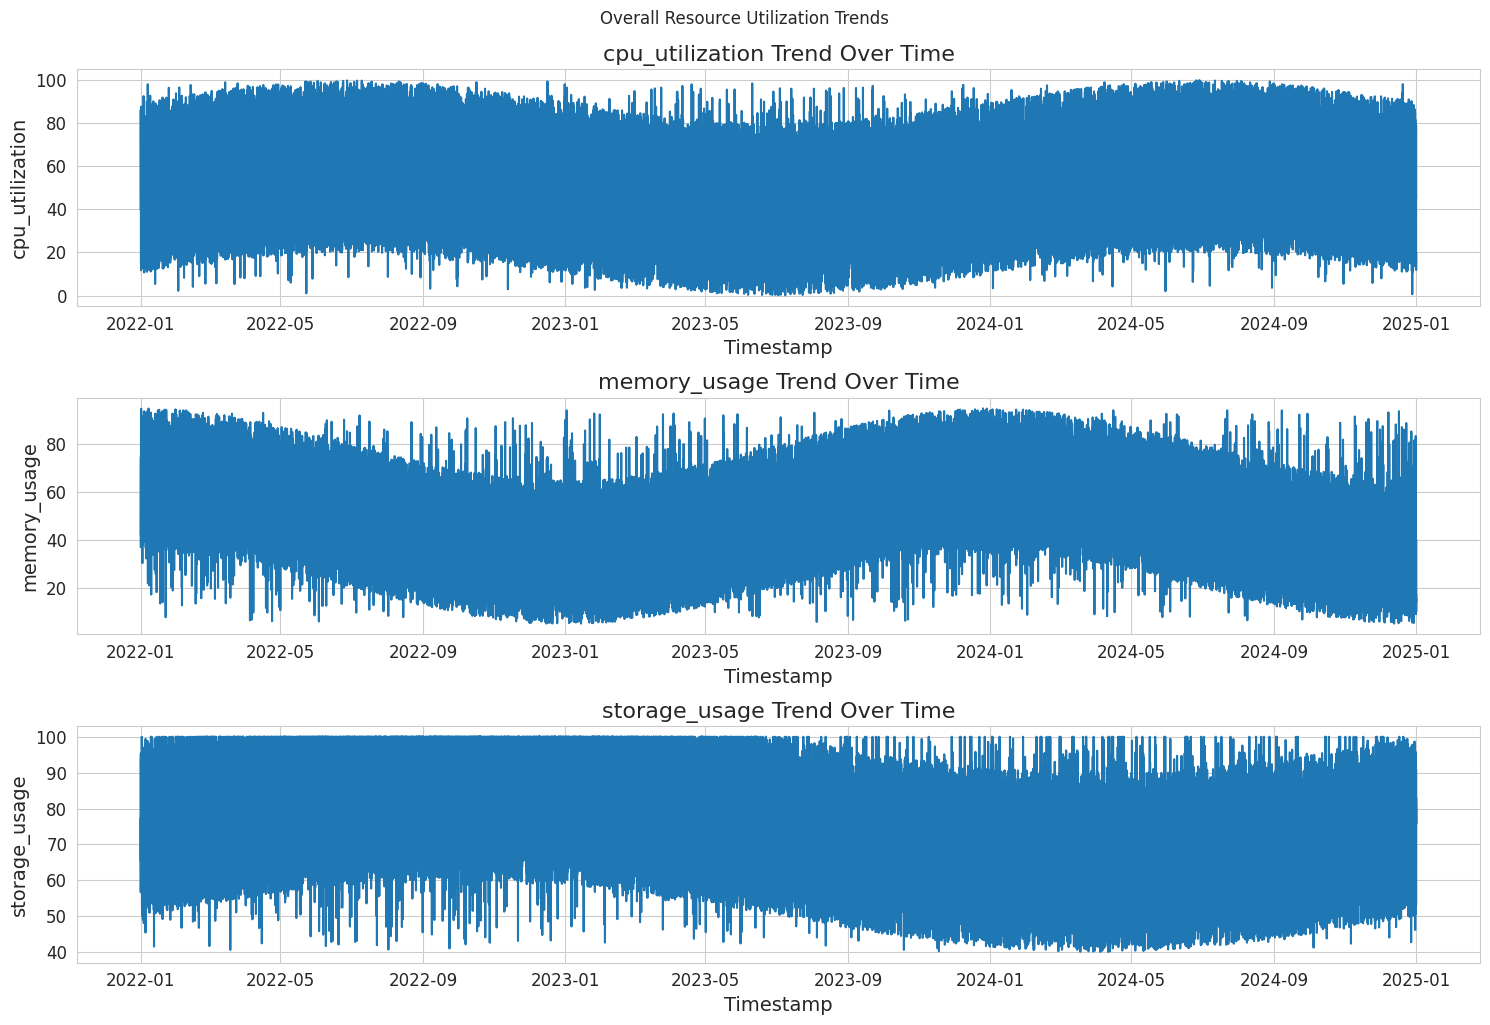

In [5]:
# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (12, 6) # 그래프 크기 기본 설정
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 1. 주요 리소스 사용량 추이 (시계열 라인 플롯)
# 시각화할 컬럼 리스트
resource_cols = ['cpu_utilization', 'memory_usage', 'storage_usage']

plt.figure(figsize=(15, 10)) # 전체 Figure 크기 설정

for i, col in enumerate(resource_cols):
    plt.subplot(len(resource_cols), 1, i + 1) 
    sns.lineplot(x='timestamp', y=col, data=df, errorbar=None)
    plt.title(f'{col} Trend Over Time')
    plt.ylabel(col)
    plt.xlabel('Timestamp')
    plt.tight_layout()

plt.suptitle('Overall Resource Utilization Trends', y=1.02)
plt.show()

## 리소스 사용량 추이 해석

이 그래프들은 2022년 초부터 2025년 초까지의 서버 리소스(CPU, 메모리, 스토리지) 사용량 변화 추이를 보여줍니다.

- 뚜렷한 연간 주기성:
    - CPU, 메모리, 스토리지: 모든 리소스 지표에서 연도별 사용량 패턴 차이가 명확하게 나타납니다.
    - CPU & 스토리지: 주로 2022년에 사용량이 높아지고, 2023~2024년에 사용량이 낮아졌다가 다시 높아지는 경향을 보입니다.
    - 메모리: 다른 두 지표와는 반대로, 2022년 여름(중순)부터 사용량이 낮아지고, 2023~2024년에 높아졌다가 다시 낮아지는 경향이 뚜렷합니다.
- 지표별 상이한 계절성 패턴:
    - CPU와 스토리지는 유사한 패턴을 보이며, 이는 해당 시기의 일반적인 서비스 활동 증가와 연관될 수 있습니다.
    - 메모리는 CPU 및 스토리지와는 다른 양상을 보입니다. 이는 특정 연도 발생하는 메모리 집약적인 워크로드(예: 대용량 데이터 처리, 이벤트/캠페인)가 존재하거나, 메모리 관리 특성 때문일 수 있습니다.
- 활용 방안: 이러한 패턴을 이해하면 리소스 사용량을 예측하고, 최적의 자원 할당 및 성능 관리 전략을 수립하는 데 활용할 수 있습니다.

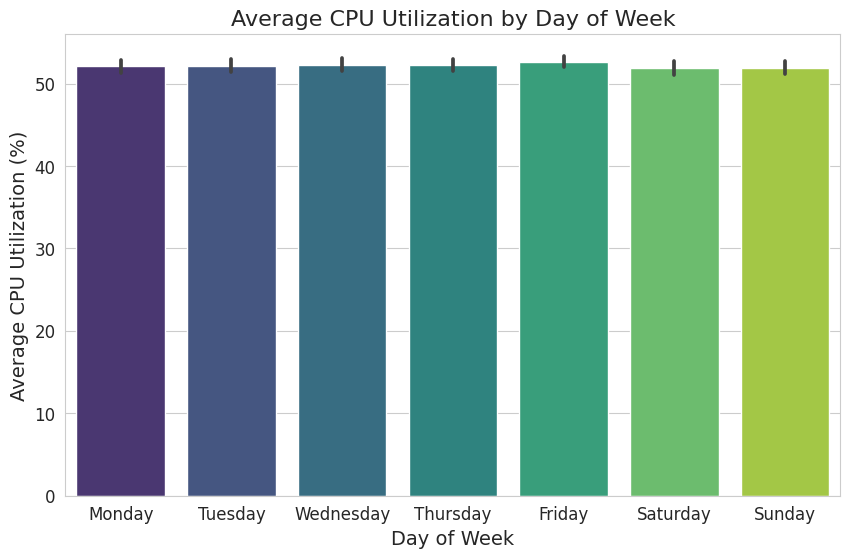

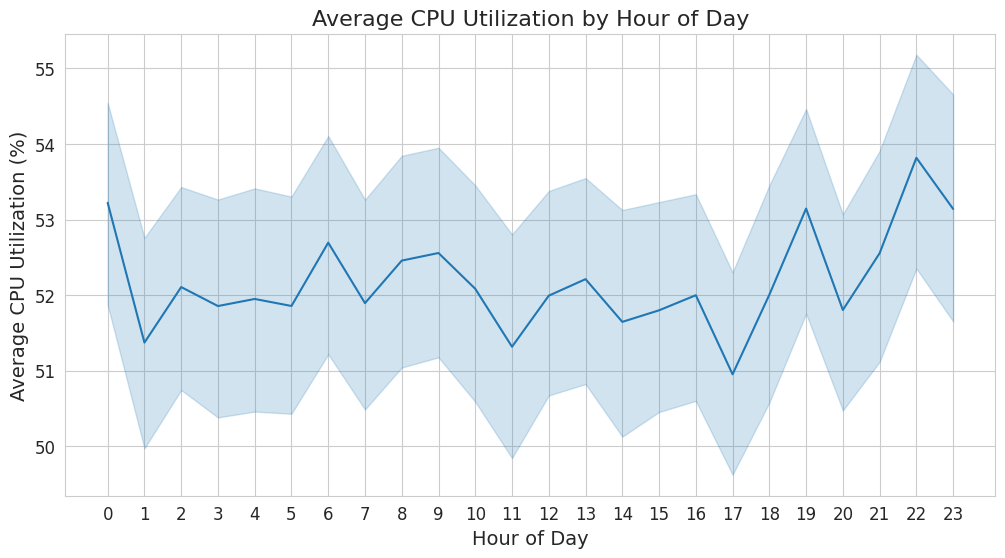

In [6]:
## 2. 요일별/시간대별 평균 리소스 사용량
# 특정 패턴, 피크 타임 등을 파악하는 데 유용합니다.

# 요일별 평균
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='cpu_utilization', data=df, estimator=np.mean, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='viridis')
plt.title('Average CPU Utilization by Day of Week')
plt.ylabel('Average CPU Utilization (%)')
plt.xlabel('Day of Week')
plt.show()

# 시간대별 평균 (CPU 사용률)
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour_of_day', y='cpu_utilization', data=df, estimator=np.mean, errorbar=('ci', 95)) # 신뢰구간 표시
plt.title('Average CPU Utilization by Hour of Day')
plt.ylabel('Average CPU Utilization (%)')
plt.xlabel('Hour of Day')
plt.xticks(range(0, 24)) # 0시부터 23시까지 모든 시간 표시
plt.show()



## 요일별/시간대별 CPU 사용량 해석
이 그래프들은 CPU 사용량의 주간(요일별) 및 일간(시간대별) 패턴을 분석한 결과입니다.

- 요일별 편차 적음: 모든 요일의 평균 CPU 사용량이 유사하게 50% 초반대를 유지합니다. 이는 이 서비스가 요일에 관계없이 꾸준히 운영되는 특성을 가짐을 시사합니다.

- 시간대별 뚜렷한 패턴: 하루 중 사용량 변동이 명확하며, 오후 늦은 시간(약 18시\~23시)에 가장 높은 사용량 피크를 보입니다.

- 활용 방안: 시간대별 패턴을 통해 사용자 활동이 집중되는 시간을 파악할 수 있으며, 이는 탄력적인 리소스 운용(예: 자동 스케일링) 및 유지보수 계획 수립에 활용될 수 있습니다.

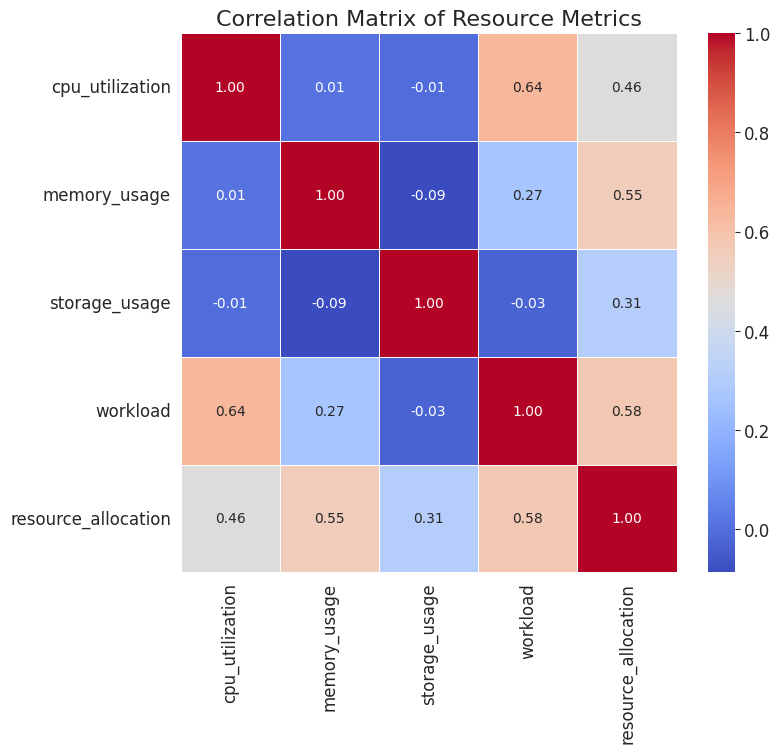

In [7]:
## 3. 리소스 간의 상관관계 히트맵
# 중요한 컬럼들만 선택하여 상관관계 히트맵 생성
# workload는 이 리소스 사용량에 직접적인 영향을 미치는 "작업량"을 나타내는 지표이므로 핵심적입니다.
# resource_allocation은 "리소스 할당량"으로, 실제 사용량과 할당량 간의 관계를 파악하는 데 중요합니다.

correlation_matrix = df[resource_cols + ['workload', 'resource_allocation']].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Resource Metrics')
plt.show()

## 리소스 지표 상관관계 해석
이 히트맵은 서버 리소스 지표들(CPU, 메모리, 스토리지, 워크로드, 리소스 할당) 간의 상관관계를 보여줍니다.

- CPU 사용량은 워크로드 및 리소스 할당과 양의 상관관계: cpu_utilization은 workload (0.50) 및 resource_allocation (0.48)과 비교적 강한 양의 상관관계를 보입니다. 이는 작업량이 늘거나 할당된 리소스가 많을수록 CPU 사용량이 증가하는 경향이 있음을 시사합니다.

- 메모리 사용량은 리소스 할당과 양의 상관관계: memory_usage는 resource_allocation (0.52)과 양의 상관관계를 보입니다.

- CPU와 메모리 사용량 간 약한 상관관계: 예상과 달리 cpu_utilization과 memory_usage 간에는 **매우 약한 상관관계(0.01)**가 나타나, 두 지표가 항상 선형적으로 함께 움직이는 것은 아님을 보여줍니다.

- 스토리지 사용량은 대부분의 지표와 약한 상관관계: storage_usage는 다른 리소스 지표들과 독립적인 경향을 보입니다.

활용 방안:

성능 최적화: 워크로드 관리 및 리소스 할당 조정이 CPU 성능에 중요함을 시사합니다.

예측 및 모니터링: 특정 지표 변화 시 연관된 다른 지표를 함께 고려하여 모니터링하고, 향후 용량 계획 수립에 활용할 수 있습니다.

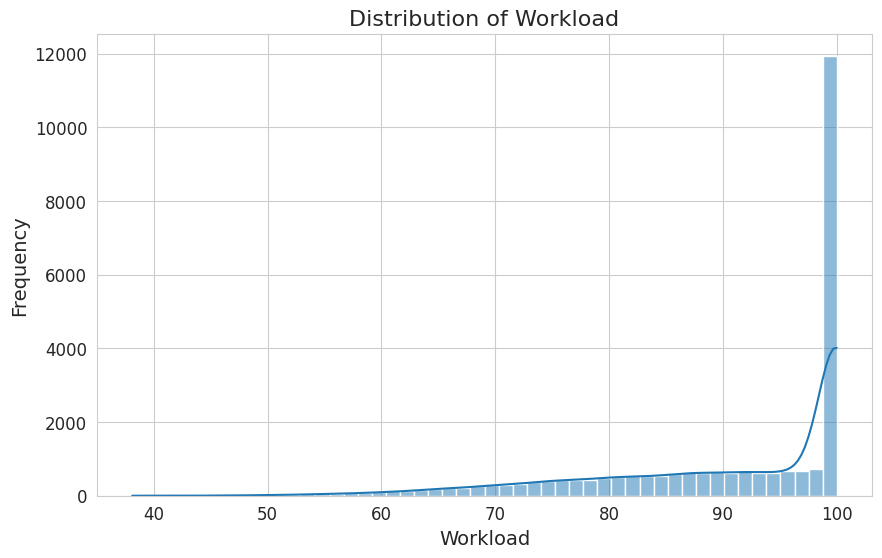

In [8]:
# 4. 'workload' 분포 히스토그램
# 'workload' 값이 100을 초과하는 것이 있어서 분포를 확인해볼 필요가 있습니다.

plt.figure(figsize=(10, 6))
sns.histplot(df['workload'], bins=50, kde=True)
plt.title('Distribution of Workload')
plt.xlabel('Workload')
plt.ylabel('Frequency')
plt.show()

## workload 분포 히스토그램

이 그래프는 workload 지표의 값 분포를 보여줍니다. 대부분의 workload는 100 근처에 집중되어 있지만, 소수의 매우 높은 값들(100 초과)도 존재합니다. 이는 시스템이 일반적으로 높은 작업량을 처리하며, 때로는 강한 피크 부하를 경험함을 시사합니다. 이 100 초과 값들은 워크로드의 절대량을 나타내는 유효한 지표로 해석될 수 있으며, 시스템의 극한 상황을 이해하는 데 활용될 수 있습니다.